<a href="https://colab.research.google.com/github/mrshamshir/Lung-Tumor-Segmentation/blob/main/Lung_Tumor_Segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Introduction

The data is provided by the medical segmentation decathlon challenge(http://medicaldecathlon.com/) <br />

(Data License: CC-BY-SA 4.0, https://creativecommons.org/licenses/by-sa/4.0/)

### Unzip data

In [ ]:
import tarfile
my_tar = tarfile.open('/content/drive/MyDrive/Copy of Task06_Lung.tar')
my_tar.extractall('./my_folder') # specify which folder to extract to
my_tar.close()

In [ ]:
from pathlib import Path

# Inspect some sample data
root = Path("/content/my_folder/Task06_Lung/imagesTr")
label = Path("/content/my_folder/Task06_Lung/labelsTr/")

In [ ]:
# Load a sample NIfTI and its corresponding label mask

def change_img_to_label_path(path):
    """
    Replaces imagesTr with labelsTr
    """
    parts = list(path.parts)  # get all directories whithin the path
    parts[parts.index("imagesTr")] = "labelsTr"  # Replace imagesTr with labelsTr
    return Path(*parts)  # Combine list back into a Path object


### Exploring data examples

In [ ]:
!pip install celluloid

In [ ]:
%matplotlib notebook
import nibabel as nib
import numpy as np
import matplotlib.pyplot as plt
from celluloid import Camera
from tqdm.notebook import tqdm
import cv2

In [ ]:
sample_path = list(root.glob("lung*"))[13]  # Choose a subject
sample_path_label = change_img_to_label_path(sample_path)

print(sample_path)
print(sample_path_label)

/content/my_folder/Task06_Lung/imagesTr/lung_041.nii.gz
/content/my_folder/Task06_Lung/labelsTr/lung_041.nii.gz


In [ ]:
# Load NIfTI and extract image data
data = nib.load(sample_path)
label = nib.load(sample_path_label)

ct = data.get_fdata()
mask = label.get_fdata()

print(mask.shape)

(512, 512, 240)


In [ ]:
# Find out the orientation
nib.aff2axcodes(data.affine)

('L', 'A', 'S')

In [ ]:
# Inspect the loaded data with overlaid Ground Truth tumor segmentation using axial view
fig = plt.figure()
camera = Camera(fig)  # create the camera object from celluloid

for i in range(0, ct.shape[2], 2):  # axial view
    plt.imshow(ct[:,:,i], cmap="bone")
    mask_ = np.ma.masked_where(mask[:,:,i]==0, mask[:,:,i])
    plt.imshow(mask_, alpha=0.5, cmap="autumn")
    #plt.axis("off")
    camera.snap()  # Store the current slice

animation = camera.animate()  # create the animation

<IPython.core.display.Javascript object>

In [ ]:
from IPython.display import HTML
HTML(animation.to_html5_video())  # convert the animation to a video

## Preprocessing

1. CT images have a fixed range from -1000 to 3071. **Thus we can normalize by dividing by 3071**
2. As we want to focus on lung tumors, we can crop away parts of the lower abdomen to reduce the complexity and help the network learn. As an example, we might skip the first 30 slices (from lower abdomen to the neck) (last axis)
3. As we want to tackle this task on a slice level (2D) and not on a subject level (3D) to reduce the computational cost we should store the preprocessed data as 2d files, because reading a single slice is much faster than loading the complete NIfTI file.
4. Resize the single slices and masks to (256, 256) (when resizing the mask, pass interpolation=cv2.INTER_NEAREST to the resize function to apply nearest neighbour interpolation)

Loop over all_files and apply the preprocessing steps. <br />
####TODO####
In the preprocessing loop, we need to create a directory for each subject containg the ct and label slices with identical names. <br />
E.g:
* 0/data/0.npy
* 0/masks/0.npy

we will store the last 6 subjects as validation data


In [17]:
all_files = list(root.glob("lung_*"))  # Get all subjects
all_files.sort()

print(all_files[3])
print(len(all_files))

/content/my_folder/Task06_Lung/imagesTr/lung_005.nii.gz
63


In [18]:
save_root = Path("/content/my_folder/Task06_Lung/Preprocessed")

train_slice_path = save_root/"train"/"data"
train_mask_path = save_root/"train"/"masks"

train_slice_path.mkdir(parents=True, exist_ok=True)
train_mask_path.mkdir(parents=True, exist_ok=True)

In [19]:
all_data = []
all_lables = []

counter = 0

for _ , path_to_ct_data in enumerate(tqdm(all_files)):

    path_to_label = change_img_to_label_path(path_to_ct_data)  # Get path to ground truth

    # Load and extract corresponding data
    ct_data = nib.load(path_to_ct_data).get_fdata()
    label_data = nib.load(path_to_label).get_fdata()

    # Crop volume and label. Remove the first 30 slices
    ct_data = ct_data[:,:,30:] / 3071
    new_label_data = label_data[:,:,30:]

    # Loop over the slices in the full volume and store the data and labels in the data/masks directory
    for i in range(ct_data.shape[-1]):
        slice = ct_data[:,:,i]
        mask = new_label_data[:,:,i]

        # Resize slice and label to common resolution to reduce training time
        slice = cv2.resize(slice, (256, 256))
        mask = cv2.resize(mask, (256, 256), interpolation=cv2.INTER_NEAREST)

        ####TODO: description of what we are doing. ####
        slice_name = f'slice_000000{100000+counter}'
        mask_name = f'mask_000000{100000+counter}'

        all_data.append(np.array([slice_name,mask_name]))
        all_lables.append(mask.any())

        counter += 1
        np.save(train_slice_path/slice_name, slice, allow_pickle=True)
        np.save(train_mask_path/mask_name, mask, allow_pickle=True)




  0%|          | 0/63 [00:00<?, ?it/s]

In [26]:
all_data_np = np.array(all_data)
all_lables_np = np.array(all_lables)

print(all_data_np.shape)
print(all_lables_np.shape)

print(np.unique(all_lables_np, return_counts=True))

(15767, 2)
(15767,)
(array([False,  True]), array([14121,  1646]))


In [27]:
from sklearn.model_selection import train_test_split

# splitting data
X_train, X_test, y_train, y_test = train_test_split(
                all_data_np,
                all_lables_np,
                test_size=0.2,
                random_state=13,
                stratify = all_lables_np, #this field can make train and validation on same distribution
                )

print("Shape of training set:", X_train.shape)
print("Shape of test set:", X_test.shape)

print(np.unique(y_train, return_counts=True))
print(np.unique(y_test, return_counts=True))

Shape of training set: (12613, 2)
Shape of test set: (3154, 2)
(array([False,  True]), array([11296,  1317]))
(array([False,  True]), array([2825,  329]))


In [28]:
val_slice_path = save_root/"val"/"data"
val_mask_path = save_root/"val"/"masks"

val_slice_path.mkdir(parents=True, exist_ok=True)
val_mask_path.mkdir(parents=True, exist_ok=True)

In [29]:
for test in X_test:
    Path(rf'{train_slice_path}/{test[0]}.npy').replace(rf'{val_slice_path}/{test[0]}.npy')
    Path(rf'{train_mask_path}/{test[1]}.npy').replace(rf'{val_mask_path}/{test[1]}.npy')

## Validate preprocessed data
Take a look at our stored files and inspect if everything worked as expected

In [37]:
for i in range (y_test.shape[0]):
    if y_test[i]:
        print(i)

1
15
38
60
69
72
76
81
90
92
93
98
99
104
119
140
156
168
169
176
182
198
204
212
220
226
228
236
256
260
277
280
301
333
345
362
370
376
381
387
395
407
408
416
426
436
457
462
473
491
493
521
525
541
568
570
583
587
595
597
614
628
646
652
661
665
673
675
702
732
736
739
751
761
776
780
784
789
791
792
796
806
820
821
835
849
857
866
873
886
905
906
913
920
936
942
947
964
965
974
1007
1011
1031
1043
1053
1065
1070
1074
1085
1090
1098
1105
1111
1123
1147
1183
1192
1194
1196
1217
1220
1224
1277
1289
1291
1296
1309
1318
1320
1322
1323
1351
1361
1367
1407
1415
1419
1429
1436
1439
1447
1454
1462
1470
1481
1487
1489
1494
1499
1501
1514
1520
1539
1541
1557
1566
1576
1620
1621
1639
1644
1665
1676
1679
1680
1686
1694
1699
1705
1719
1723
1736
1739
1742
1748
1755
1768
1773
1776
1783
1802
1806
1809
1812
1816
1824
1844
1848
1853
1858
1866
1867
1871
1875
1880
1883
1885
1896
1925
1936
1945
1951
1956
1983
1988
2004
2007
2035
2043
2046
2052
2056
2080
2081
2092
2103
2125
2134
2152
2155
2177
2189
2191

In [33]:
test = X_test[2638]

slice_path = Path(val_slice_path/test[0])  # Select a subject. Check the folder if it exists
mask_path = Path(val_mask_path/test[1])  # Select a subject. Check the folder if it exists

# Choose a file and load slice + mask

slice = np.load(str(slice_path) + '.npy')
mask = np.load(str(mask_path) + '.npy')
print(slice.shape)
print(slice.min(), slice.max())

(256, 256)
-0.33344187561055033 0.4849397590361446


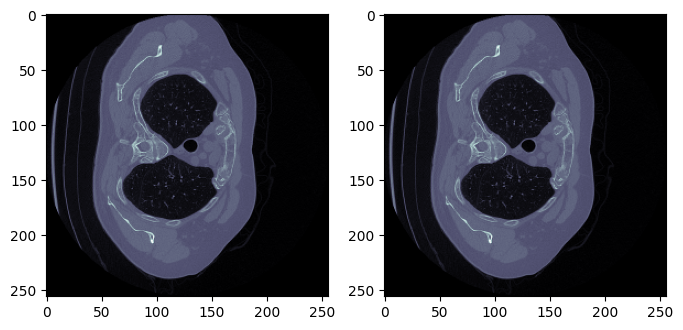

In [36]:
%matplotlib inline
fig, axis = plt.subplots(1, 2, figsize=(8, 8))
axis[0].imshow(slice, cmap="bone")
mask_ = np.ma.masked_where(mask==0, mask)
axis[1].imshow(slice, cmap="bone")
axis[1].imshow(mask_, cmap="autumn")


## Train

In [ ]:
!pip install pytorch_lightning
!pip uninstall imgaug
!pip install imgaug

In [39]:
from pathlib import Path

import torch
import pytorch_lightning as pl
from pytorch_lightning.callbacks import ModelCheckpoint
from pytorch_lightning.loggers import TensorBoardLogger
import imgaug
import imgaug.augmenters as iaa
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from celluloid import Camera
from imgaug.augmentables.segmaps import SegmentationMapsOnImage

### Dataset Creation

In [43]:
class LungDataset(torch.utils.data.Dataset):
    def __init__(self, root, augment_params):
        self.all_files = self.extract_files(root)
        self.augment_params = augment_params

    @staticmethod
    def extract_files(root):
        """
        Extract the paths to all slices given the root path (ends with train or val)
        """
        files = []
        slice_path = root/"data"  # Get the slices for current subject
        for slice in slice_path.glob("*"):
            files.append(slice)
        return files

    @staticmethod
    def change_img_to_label_path(path):
        """
        Replace data with mask to get the masks
        """
        parts = list(path.parts)
        parts[-2] = "masks"
        parts[-1] = parts[-1].replace('slice','mask')
        return Path(*parts)

    def augment(self, slice, mask):
        """
        Augments slice and segmentation mask in the exact same way
        Note the manual seed initialization
        """
        ###################IMPORTANT###################
        # Fix for https://discuss.pytorch.org/t/dataloader-workers-generate-the-same-random-augmentations/28830/2
        random_seed = torch.randint(0, 1000000, (1,))[0].item()
        imgaug.seed(random_seed)
        #####################################################

        new_mask = mask.astype(bool)

        mask = SegmentationMapsOnImage(new_mask, new_mask.shape)
        slice_aug, mask_aug = self.augment_params(image=slice, segmentation_maps=mask)
        mask_aug = mask_aug.get_arr()
        return slice_aug, mask_aug

    def __len__(self):
        """
        Return the length of the dataset (length of all files)
        """
        return len(self.all_files)

    def __getitem__(self, idx):
        """
        Given an index return the (augmented) slice and corresponding mask
        Add another dimension for pytorch
        """
        file_path = self.all_files[idx]
        mask_path = self.change_img_to_label_path(file_path)
        slice = np.load(file_path)
        mask = np.load(mask_path)

        if self.augment_params:
            slice, mask = self.augment(slice, mask)
        return np.expand_dims(slice, 0), np.expand_dims(mask, 0)


In [44]:
seq = iaa.Sequential([
    iaa.Affine(translate_percent=(0.15),
               scale=(0.85, 1.15), # zoom in or out
               rotate=(-45, 45)#
               ),  # rotate up to 45 degrees
    iaa.ElasticTransformation()  # Elastic Transformations
                ])


In [45]:
# Create the dataset objects
train_path = Path("/content/my_folder/Task06_Lung/Preprocessed/train/")
val_path = Path("/content/my_folder/Task06_Lung/Preprocessed/val/")

train_dataset = LungDataset(train_path, seq)
val_dataset = LungDataset(val_path, None)

print(f"There are {len(train_dataset)} train images and {len(val_dataset)} val images")

There are 12613 train images and 3154 val images


### Oversampling to tackle strong class imbalance
Lung tumors are often very small, thus we need to make sure that our model does not learn a trivial solution which simply outputs 0 for all voxels.<br />
So, we will use oversampling to sample slices which contain a tumor more often.

In [46]:
# create a list containing only the class labels
target_list = []
for _, label in tqdm(train_dataset):
    # Check if mask contains a tumorous pixel:
    if np.any(label):
        target_list.append(1)
    else:
        target_list.append(0)

  0%|          | 0/12613 [00:00<?, ?it/s]

In [47]:
# calculate the weight for each class
uniques = np.unique(target_list, return_counts=True)
print(uniques)

fraction = uniques[1][0] / uniques[1][1]
print(fraction)

(array([0, 1]), array([11298,  1315]))
8.591634980988593


In [48]:
weight_list = []

for target in target_list:
    if target == 0:
        weight_list.append(1)
    else:
        weight_list.append(fraction)

print(weight_list[:50])

[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 8.591634980988593, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 8.591634980988593, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


In [49]:
# Finally we create the sampler which we can pass to the DataLoader.
sampler = torch.utils.data.sampler.WeightedRandomSampler(weight_list, len(weight_list))


In [50]:
batch_size = 8    #TODO
num_workers = 2    # TODO


train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size,
                                           num_workers=num_workers, sampler=sampler)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, num_workers=num_workers, shuffle=False)


### test sampler, images and labels

In [51]:
# We can verify that our sampler works by taking a batch from the train loader and count how many labels are larger than zero
verify_sampler = next(iter(train_loader))  # Take one batch

In [54]:
print(verify_sampler[1].shape)
temp = np.any(np.array(verify_sampler[1]), axis =(1,2,3))
print(temp)
slice = verify_sampler[0][1].squeeze()
mask = verify_sampler[1][1].squeeze()
print(slice.shape)

torch.Size([8, 1, 256, 256])
[ True  True  True  True  True False  True False]
torch.Size([256, 256])


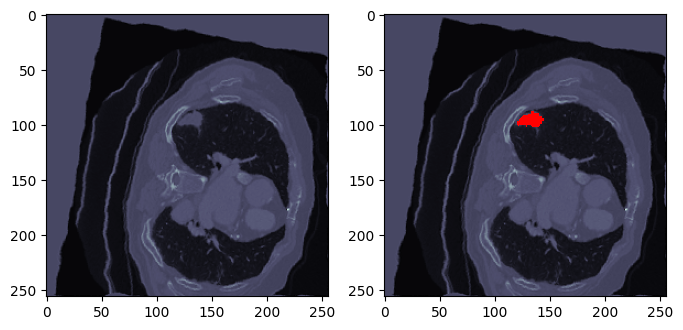

In [55]:
%matplotlib inline
fig, axis = plt.subplots(1, 2, figsize=(8, 8))
axis[0].imshow(slice, cmap="bone")
mask_ = np.ma.masked_where(mask==0, mask)
axis[1].imshow(slice, cmap="bone")
axis[1].imshow(mask_, cmap="autumn")

### Loss

As this is a harder task to train we might try different loss functions:
We achieved best results by using the Binary Cross Entropy instead of the Dice Loss

In [56]:
class DoubleConv(torch.nn.Module):
    """
    Helper Class which implements the intermediate Convolutions
    """
    def __init__(self, in_channels, out_channels):

        super().__init__()
        self.step = torch.nn.Sequential(torch.nn.Conv2d(in_channels, out_channels, 3, padding=1),
                                        torch.nn.ReLU(),
                                        torch.nn.Conv2d(out_channels, out_channels, 3, padding=1),
                                        torch.nn.ReLU())

    def forward(self, X):
        return self.step(X)


In [57]:
class UNet(torch.nn.Module):
    """
    This class implements a UNet for the Segmentation
    We use 3 down- and 3 UpConvolutions and two Convolutions in each step
    """

    def __init__(self):
        """Sets up the U-Net Structure
        """
        super().__init__()


        ############# DOWN #####################
        self.layer1 = DoubleConv(1, 64)
        self.layer2 = DoubleConv(64, 128)
        self.layer3 = DoubleConv(128, 256)
        self.layer4 = DoubleConv(256, 512)

        #########################################

        ############## UP #######################
        self.layer5 = DoubleConv(512 + 256, 256)
        self.layer6 = DoubleConv(256+128, 128)
        self.layer7 = DoubleConv(128+64, 64)
        self.layer8 = torch.nn.Conv2d(64, 1, 1)
        #########################################

        self.maxpool = torch.nn.MaxPool2d(2)

    def forward(self, x):

        ####### DownConv 1#########
        x1 = self.layer1(x)
        x1m = self.maxpool(x1)
        ###########################

        ####### DownConv 2#########
        x2 = self.layer2(x1m)
        x2m = self.maxpool(x2)
        ###########################

        ####### DownConv 3#########
        x3 = self.layer3(x2m)
        x3m = self.maxpool(x3)
        ###########################

        ##### Intermediate Layer ##
        x4 = self.layer4(x3m)
        ###########################

        ####### UpCONV 1#########
        x5 = torch.nn.Upsample(scale_factor=2, mode="bilinear")(x4)  # Upsample with a factor of 2
        #x5 = torch.nn.ConvTranspose2d(512, 512, 2, 2)(x4)
        x5 = torch.cat([x5, x3], dim=1)  # Skip-Connection
        x5 = self.layer5(x5)
        ###########################

        ####### UpCONV 2#########
        x6 = torch.nn.Upsample(scale_factor=2, mode="bilinear")(x5)
        #x6 = torch.nn.ConvTranspose2d(256, 256, 2, 2)(x5)
        x6 = torch.cat([x6, x2], dim=1)  # Skip-Connection
        x6 = self.layer6(x6)
        ###########################

        ####### UpCONV 3#########
        x7 = torch.nn.Upsample(scale_factor=2, mode="bilinear")(x6)
        #x7 = torch.nn.ConvTranspose2d(128, 128, 2, 2)(x6)
        x7 = torch.cat([x7, x1], dim=1)
        x7 = self.layer7(x7)
        ###########################

        ####### Predicted segmentation#########
        ret = self.layer8(x7)
        return ret


In [58]:
# Full Segmentation Model
class TumorSegmentation(pl.LightningModule):
    def __init__(self):
        super().__init__()

        self.model = UNet()

        self.optimizer = torch.optim.Adam(self.model.parameters(), lr=1e-4)
        self.loss_fn = torch.nn.BCEWithLogitsLoss()

    def forward(self, data):
        pred = self.model(data)
        return pred

    def training_step(self, batch, batch_idx):
        ct, mask = batch
        # print(type(ct),type(mask))
        # print(ct.dtype,mask.dtype)
        # print(ct.shape, mask.shape)

        mask = mask.float()
        ct = ct.float()

        # print(type(ct),type(mask))
        # print(ct.dtype,mask.dtype)
        # print(ct.shape, mask.shape)

        pred = self(ct)
        loss = self.loss_fn(pred, mask)

        # Logs
        self.log("Train Dice", loss)
        if batch_idx % 50 == 0:
            self.log_images(ct.cpu(), pred.cpu(), mask.cpu(), "Train")
        return loss


    def validation_step(self, batch, batch_idx):
        ct, mask = batch
        mask = mask.float()
        ct = ct.float()

        pred = self(ct)
        loss = self.loss_fn(pred, mask)

        # Logs
        self.log("Val Dice", loss)
        if batch_idx % 50 == 0:
            self.log_images(ct.cpu(), pred.cpu(), mask.cpu(), "Val")

        return loss


    def log_images(self, ct, pred, mask, name):

        results = []

        pred = pred > 0.5 # As we use the sigomid activation function, we threshold at 0.5


        fig, axis = plt.subplots(1, 2)
        axis[0].imshow(ct[0][0], cmap="bone")
        mask_ = np.ma.masked_where(mask[0][0]==0, mask[0][0])
        axis[0].imshow(mask_, alpha=0.6)
        axis[0].set_title("Ground Truth")

        axis[1].imshow(ct[0][0], cmap="bone")
        mask_ = np.ma.masked_where(pred[0][0]==0, pred[0][0])
        axis[1].imshow(mask_, alpha=0.6, cmap="autumn")
        axis[1].set_title("Pred")

        self.logger.experiment.add_figure(f"{name} Prediction vs Label", fig, self.global_step)



    def configure_optimizers(self):
        #We always need to return a list here (just pack our optimizer into one :))
        return [self.optimizer]



In [59]:
# Instanciate the model
model = TumorSegmentation()

# Create the checkpoint callback
checkpoint_callback = ModelCheckpoint(
    monitor='Val Dice',
    save_top_k=30,
    mode='min')

# Create the trainer
trainer = pl.Trainer(accelerator="auto",
                     logger=TensorBoardLogger(save_dir="/content/drive/MyDrive/output"),
                     log_every_n_steps=1,
                     callbacks=checkpoint_callback,
                     max_epochs=30)


INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


In [ ]:
trainer.fit(model, train_loader, val_loader,
            # ckpt_path = "/content/drive/MyDrive/output/lightning_logs/version_1/checkpoints/epoch=20-step=33117.ckpt"
            )

In [ ]:
%reload_ext tensorboard
%tensorboard --logdir /content/drive/MyDrive/output/lightning_logs/

### Evaluation:
Let's evaluate the results

In [69]:
class DiceScore(torch.nn.Module):
    """
    class to compute the Dice Loss
    """
    def __init__(self):
        super().__init__()

    def forward(self, pred, mask):

        #flatten label and prediction tensors
        pred = torch.flatten(pred)
        mask = torch.flatten(mask)

        counter = (pred * mask).sum()  # Counter
        denum = pred.sum() + mask.sum()  # denominator
        dice = (2*counter)/denum

        return dice


In [73]:
model = TumorSegmentation.load_from_checkpoint("/content/drive/MyDrive/output/lightning_logs/version_2/checkpoints/epoch=29-step=47310.ckpt",
                                               map_location=torch.device('cpu'))
model.eval();
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.to(device);

In [ ]:
preds = []
labels = []

for slice, label in tqdm(val_dataset):
    slice = torch.tensor(slice).float().to(device).unsqueeze(0)
    with torch.no_grad():
        pred = torch.sigmoid(model(slice))
    preds.append(pred.cpu().numpy())
    labels.append(label)

preds = np.array(preds)
labels = np.array(labels)

  0%|          | 0/3154 [00:00<?, ?it/s]

In [ ]:
dice_score = DiceScore()(torch.from_numpy(preds), torch.from_numpy(labels).unsqueeze(0).float())
print(f"The Val Dice Score is: {dice_score}")

The Val Dice Score is: 0.8783138394355774


### Visualization


In [70]:
import nibabel as nib
import cv2

In [71]:
subject = Path("/content/my_folder/Task06_Lung/imagesTs/lung_013.nii.gz")
ct = nib.load(subject).get_fdata() / 3071  # standardize
ct = ct[:,:,30:]  # crop

In [74]:
segmentation = []
label = []
scan = []
THRESHOLD = 0.5

for i in range(ct.shape[-1]):
    slice = ct[:,:,i]
    slice = cv2.resize(slice, (256, 256))
    slice = torch.tensor(slice)
    scan.append(slice)
    slice = slice.unsqueeze(0).unsqueeze(0).float().to(device)

    with torch.no_grad():
        pred = model(slice)[0][0].cpu()
    pred = pred > THRESHOLD
    segmentation.append(pred)
    label.append(segmentation)


In [75]:
# Plotting the predicted segmentation (red)
%matplotlib notebook
fig = plt.figure()
camera = Camera(fig)  # create the camera object from celluloid

for i in range(0, len(scan), 2):  # Sagital view. Skip every second slice to reduce the video length
    plt.imshow(scan[i], cmap="bone")
    mask = np.ma.masked_where(segmentation[i]==0, segmentation[i])
    plt.imshow(mask, alpha=0.5, cmap="autumn")  # Use autumn colormap to get red segmentation

    plt.axis("off")
    camera.snap()  # Store the current slice
animation = camera.animate()  # create the animation

<IPython.core.display.Javascript object>

In [76]:
from IPython.display import HTML
HTML(animation.to_html5_video())  # convert the animation to a video